# Run the clean.py ```notebooks > scripts > clean.py``` to remove data from the mySQL tables before running this script.

In [1]:
from scripts.StreamProcessing import Stream_Data, ClimateChangeDataset # found in the scripts folder inside StreamProcessing.py. This class uses PySpark

PySpark found


https://berkeleyearth.org/data/

### A note on block 

These might take a while as PySpark attempts to download some additional files

In [2]:
# Initialize the Stream_Data Class using the topic name/s established in the kafka-config/kafka-config.ipynb and add the host of your kafka instance in the host parameter
emissions_config = Stream_Data(topics='ghg_data', host='localhost:9092')
e_session, query, emissions_df = emissions_config.getData()
#temperatures

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/mysql-connector-j-8.0.33.jar
/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar


23/05/22 00:35:24 WARN Utils: Your hostname, camagakhan-Inspiron-7577 resolves to a loopback address: 127.0.1.1; using 192.168.6.119 instead (on interface wlp60s0)
23/05/22 00:35:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/camagakhan/spark-3.4.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/camagakhan/.ivy2/cache
The jars for the packages stored in: /home/camagakhan/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5dfb6cc2-9b14-4e9e-84b3-2f5625bf1e89;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-10_2.12;3.2.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.0 in central
	found org.apache.kafka#kafka-clients;2.8.0 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in central
	found commons-logging#com

In [ ]:
# Initialize the Stream_Data Class using the topic name/s established in the kafka-config/kafka-config.ipynb and add the host of your kafka instance in the host parameter
C02_config = Stream_Data(topics='C02', host='localhost:9092')
c02_session, query_c02, C02_df = C02_config.getData()

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/mysql-connector-j-8.0.33.jar
/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar


Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----------+---------+----+-----+
|    Country|Pollutant|Year|Value|
+-----------+---------+----+-----+
|Afghanistan|      GHG|1990| 9.58|
|Afghanistan|      GHG|1991| 9.81|
|Afghanistan|      GHG|1992| 9.03|
|Afghanistan|      GHG|1993| 9.11|
|Afghanistan|      GHG|1994| 9.15|
|Afghanistan|      GHG|1995| 9.58|
|Afghanistan|      GHG|1996|10.61|
|Afghanistan|      GHG|1997|11.58|
|Afghanistan|      GHG|1998| 12.4|
|Afghanistan|      GHG|1999|13.28|
|Afghanistan|      GHG|2000| 11.5|
|Afghanistan|      GHG|2001|12.37|
|Afghanistan|      GHG|2002|15.01|
|Afghanistan|      GHG|2003|15.65|
|Afghanistan|      GHG|2004|15.44|
|Afghanistan|      GHG|2005|16.35|
|Afghanistan|      GHG|2006|16.87|
|Afghanistan|      GHG|2007|17.26|
|Afghanistan|      GHG|2008|20.66|
|Afghanistan|      GHG|2009|22.75|
+-----------+---------+----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 0
-------------------------------------------
+-----------+----+----+------------+
|     Entity|Code|Year|       Value|
+-----------+----+----+------------+
|Afghanistan| AFG|1949|0.0019223358|
|Afghanistan| AFG|1950| 0.011265611|
|Afghanistan| AFG|1951| 0.012097932|
|Afghanistan| AFG|1952| 0.011946474|
|Afghanistan| AFG|1953| 0.013684762|
|Afghanistan| AFG|1954| 0.013511202|
|Afghanistan| AFG|1955| 0.019303724|
|Afghanistan| AFG|1956| 0.022651596|
|Afghanistan| AFG|1957|   0.0357019|
|Afghanistan| AFG|1958| 0.039568856|
|Afghanistan| AFG|1959|  0.04541344|
|Afghanistan| AFG|1960|  0.04800073|
|Afghanistan| AFG|1961|  0.05583506|
|Afghanistan| AFG|1962|  0.07677442|
|Afghanistan| AFG|1963|  0.07717596|
|Afghanistan| AFG|1964|  0.08963178|
|Afghanistan| AFG|1965|  0.10526929|
|Afghanistan| AFG|1966|  0.11153449|
|Afghanistan| AFG|1967|  0.12805797|
|Afghanistan| AFG|1968| 0.119381055|
+-----------+----+----+------------+
only showing to

In [ ]:
# Initialize the Stream_Data Class using the topic name/s established in the kafka-config/kafka-config.ipynb and add the host of your kafka instance in the host parameter
temperature_config = Stream_Data(topics='temperature', host='localhost:9092')
t_session, query_temperature, temperature_df = temperature_config.getData()

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/mysql-connector-j-8.0.33.jar
/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar


-------------------------------------------
Batch: 0
-------------------------------------------
+--------+--------------------+------------------+-----------+---------+--------+
|REF_AREA|             Measure|      UNIT_MEASURE|TIME_PERIOD|OBS_VALUE|REF_CODE|
+--------+--------------------+------------------+-----------+---------+--------+
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1979|    -0.55|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1980|    -0.17|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1981|    -0.48|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1982|    -0.53|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1983|    -0.89|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1984|    -0.82|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1985|    -0.43|     YEM|
|   Yemen|TEMP_C: Annual te...|C: Degrees celsius|       1986|    -0.53|     YEM|
|

### NOTE
Everything is configered while initializing the PySpark Session in the ```StreamProcessing.py``` class. DO NOT remove the ```from graphframes import GraphFrame```, as the jar files are loaded while getting the data from the previous code block

In [5]:
from graphframes import GraphFrame
import findspark as tt
tt.init(emissions_config.getSpark_Path()) 
from pyspark.sql import functions as F
from pyspark.sql.functions import dense_rank, lit
from pyspark.sql.window import Window

In [6]:
print(temperature_df)
print(emissions_df)
print(C02_df)

DataFrame[REF_AREA: string, Measure: string, UNIT_MEASURE: string, TIME_PERIOD: int, OBS_VALUE: double, REF_CODE: string]
DataFrame[Country: string, Pollutant: string, Year: int, Value: double]
DataFrame[Entity: string, Code: string, Year: int, Value: double]


In [7]:
emissions_df.columns

['Country', 'Pollutant', 'Year', 'Value']

In [8]:
#temp_df = temperature_df.withColumnRenamed('REF_CODE','COUNTRY_CODE')
ghg_df = emissions_df.withColumnRenamed('Pollutant','POL')
ghg_df = ghg_df.withColumn('COUNTRY_CODE',lit('MLT'))

C02_temp_df = C02_df.withColumnRenamed('Entity','Country')
C02_temp_df = C02_temp_df.withColumn('POL', lit('C02'))
C02_temp_df = C02_temp_df.withColumnRenamed('Code','COUNTRY_CODE')

print(ghg_df.columns)
print(C02_temp_df.columns)

# myDataset = temp_df.join(ghg_df, (temp_df.REF_AREA == ghg_df.Country) & (temp_df.TIME_PERIOD == ghg_df.Year) & (temp_df.COUNTRY_CODE == 'MLT'), 'inner')
# myDataset = myDataset.select(temp_df.COUNTRY_CODE, ghg_df.Country,ghg_df.Year, temp_df.UNIT_MEASURE, temp_df.OBS_VALUE, ghg_df.POL, ghg_df.Value)
# C02ML = temp_df.join(C02_temp_df, (temp_df.COUNTRY_CODE == C02_temp_df.Code) & (temp_df.TIME_PERIOD == C02_temp_df.Year) & (temp_df.COUNTRY_CODE == 'MLT'), 'inner')
# C02ML = C02ML.select(temp_df.COUNTRY_CODE, C02_temp_df.Country, C02_temp_df.Year, temp_df.UNIT_MEASURE, temp_df.OBS_VALUE, C02_temp_df.POL, C02_temp_df.Value)
# ran into out of memory exception

# We'll be assigning the country_codes as ids to map relationships


['Country', 'POL', 'Year', 'Value', 'COUNTRY_CODE']
['Country', 'COUNTRY_CODE', 'Year', 'Value', 'POL']


In [9]:
myDataset = ghg_df.select(ghg_df.COUNTRY_CODE, ghg_df.Country, ghg_df.Year, ghg_df.POL, ghg_df.Value).where(ghg_df.Country == 'Malta')
C02ML = C02_temp_df.select(C02_temp_df.COUNTRY_CODE, C02_temp_df.Country, C02_temp_df.Year, C02_temp_df.POL, C02_temp_df.Value).where(C02_temp_df.COUNTRY_CODE == 'MLT')

Store the Dataset before we attempt to use models

In [10]:
config_train = Stream_Data(topics=None, host='localhost:9092')
config_train.storeData('climate_change', myDataset) # we are about to store the new dataset in a mySQL table

In [11]:
C02_Config_train = Stream_Data(topics=None, host='localhost:9092')
C02_Config_train.storeData('C02ML', C02ML)

# Machine Learning Section.

In [12]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# For Greenhouse Gases

In the following code block we are setting up the Linear Regression to set up a model to predict the temperatures based on the given Green house Gases levels

In [13]:
climate_change_df = ClimateChangeDataset().loadDataset()
climate_change_df.show()
# Don't mind the nulls

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar
+------------+-------+----+------------+---------+---+-----+
|COUNTRY_CODE|Country|Year|UNIT_MEASURE|OBS_VALUE|POL|Value|
+------------+-------+----+------------+---------+---+-----+
|         MLT|  Malta|1990|        null|     null|GHG| 2.53|
|         MLT|  Malta|1991|        null|     null|GHG| 2.43|
|         MLT|  Malta|1992|        null|     null|GHG| 2.41|
|         MLT|  Malta|1993|        null|     null|GHG| 3.06|
|         MLT|  Malta|1994|        null|     null|GHG| 2.76|
|         MLT|  Malta|1995|        null|     null|GHG| 2.63|
|         MLT|  Malta|1996|        null|     null|GHG| 2.58|
|         MLT|  Malta|1997|        null|     null|GHG| 2.73|
|         MLT|  Malta|1998|        null|     null|GHG| 2.64|
|         MLT|  Malta|1999|        null|     null|GHG| 2.68|
|         MLT|  Malta|2000|        null|     null|GHG| 

In [14]:
climate_change_df.stat.corr('Year', 'Value')

-0.20751094772714487

### Dataset Analysis

In [15]:
import matplotlib.pyplot as plt

In [16]:
import matplotlib.pyplot as plt
dataset = climate_change_df.toPandas()[['POL','COUNTRY_CODE', 'Country', 'Year', 'Value']]
dataset

,POL,COUNTRY_CODE,Country,Year,Value
0,GHG,MLT,Malta,1990,2.53
1,GHG,MLT,Malta,1991,2.43
2,GHG,MLT,Malta,1992,2.41
3,GHG,MLT,Malta,1993,3.06
4,GHG,MLT,Malta,1994,2.76
5,GHG,MLT,Malta,1995,2.63
6,GHG,MLT,Malta,1996,2.58
7,GHG,MLT,Malta,1997,2.73
8,GHG,MLT,Malta,1998,2.64
9,GHG,MLT,Malta,1999,2.68


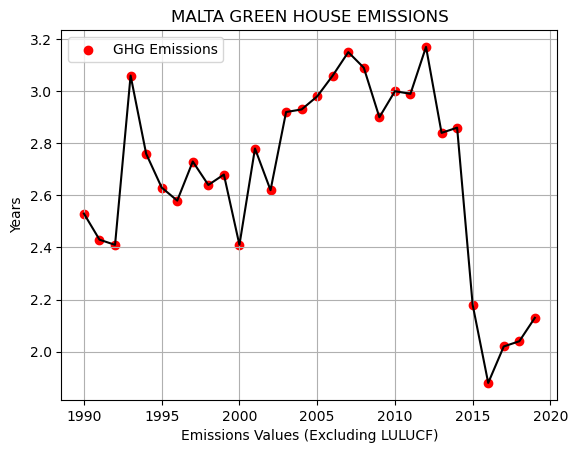

In [17]:
x, y = dataset['Year'], dataset['Value']
plt.scatter(x,y, color='red', label='GHG Emissions')
plt.plot(x,y, color='black')
plt.grid()
plt.legend()
plt.title('MALTA GREEN HOUSE EMISSIONS')
plt.xlabel('Emissions Values (Excluding LULUCF)')
plt.ylabel('Years')
plt.show()

The Graph shows quite a scatter of Emissions. This is not linear.

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [19]:
x_train, x_test = train_test_split(dataset, test_size=.2, random_state=1)#dataset[dataset['Year'] <= 2005], dataset[dataset['Year'] > 2005]

(len(x_train), len(x_test))

(24, 6)

In [20]:
X, y = x_train[['Year']], x_train['Value']
x_test, y_test = x_test[['Year']], x_test['Value']


In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
DEGREE = 4
poly_features = PolynomialFeatures(degree=DEGREE)
x_poly = poly_features.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(x_poly, y)

# Predict using the trained model
x_test_poly = poly_features.transform(x_test)
y_pred = model.predict(x_test_poly)

print(model.score(x_poly,y))

# Print the predicted value
print("Predicted value:", y_test, y_pred)

0.6389902974060053
Predicted value: 17    3.15
21    2.99
10    2.41
19    2.90
14    2.93
20    3.00
Name: Value, dtype: float64 [2.97962783 2.87329701 2.80942699 2.95313158 2.94320145 2.9205642 ]


In [22]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Coefficient of Determination (R-squared):', r2)

Mean Squared Error (MSE): 0.03524924497497566
Mean Absolute Error (MAE): 0.13871182883158326
Coefficient of Determination (R-squared): 0.3422284785926166


In [23]:
p = np.array([2022,2023,2030]).reshape(-1,1)
to_predict = poly_features.transform(p)
y_pred30 = model.predict(to_predict)
y_pred30

array([ 0.99055007,  0.65962321, -2.64893401])

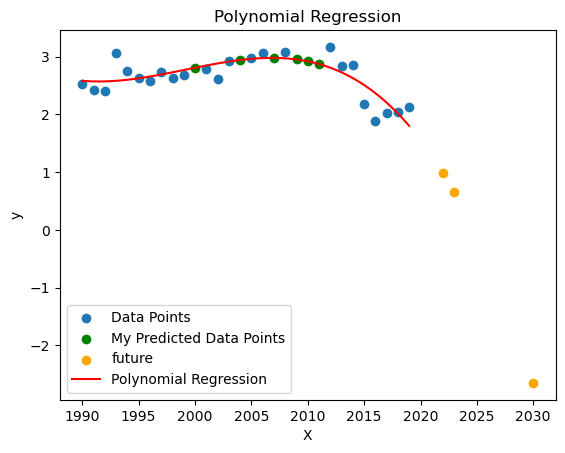

In [24]:
# Plot the original data points and the polynomial regression curve

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(x_range)

# Predict using the trained model
y_pred2 = model.predict(x_range_poly)

plt.scatter(X, y, label='Data Points')
plt.scatter(x_test, y_pred, label='My Predicted Data Points', color='green')
plt.scatter(p, y_pred30, color='orange', label='future')
plt.plot(x_range, y_pred2, color='r', label='Polynomial Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Polynomial Regression')
plt.show()

# For C02

In [25]:
C02_change_df = ClimateChangeDataset(table='C02ML').loadDataset()
C02_change_df.show()

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar
+------------+-------+----+------------+---------+---+----------+
|COUNTRY_CODE|Country|Year|UNIT_MEASURE|OBS_VALUE|POL|     VALUE|
+------------+-------+----+------------+---------+---+----------+
|         MLT|  Malta|1950|        null|     null|C02| 0.8410551|
|         MLT|  Malta|1951|        null|     null|C02| 0.8600911|
|         MLT|  Malta|1952|        null|     null|C02| 0.7935993|
|         MLT|  Malta|1953|        null|     null|C02| 0.7412122|
|         MLT|  Malta|1954|        null|     null|C02|0.96855265|
|         MLT|  Malta|1955|        null|     null|C02| 1.0529842|
|         MLT|  Malta|1956|        null|     null|C02| 0.9028419|
|         MLT|  Malta|1957|        null|     null|C02| 0.9363603|
|         MLT|  Malta|1958|        null|     null|C02|0.98331326|
|         MLT|  Malta|1959|        null|     null|C02| 1

In [135]:
# C02_change_df = C02_change_df.withColumn('Partition', dense_rank().over(Window.partitionBy('COUNTRY_CODE').orderBy('Year')))
# C02_change_df.show()

In [47]:
# train, test = C02_change_df.randomSplit([0.8, 0.2], seed=42)

## Correlation between Year and C02 Emissions (C02)

In [26]:
C02_change_df.stat.corr('Year', 'Value')

0.7516966106289076

Dataset disproves what this paper said; that temperature rise has a direct relationship with C02. Reason being is that most countries are gradually removing GHGs from their portfolio https://link.springer.com/article/10.1007/s10584-021-03001-7

### Predictions =]

In [27]:
malta = C02_change_df.toPandas()[['COUNTRY_CODE', 'Country', 'Year', 'POL', 'VALUE']]
malta

,COUNTRY_CODE,Country,Year,POL,VALUE
0,MLT,Malta,1950,C02,0.841055
1,MLT,Malta,1951,C02,0.860091
2,MLT,Malta,1952,C02,0.793599
3,MLT,Malta,1953,C02,0.741212
4,MLT,Malta,1954,C02,0.968553
...,...,...,...,...,...
67,MLT,Malta,2017,C02,3.192608
68,MLT,Malta,2018,C02,3.146826
69,MLT,Malta,2019,C02,3.274508
70,MLT,Malta,2020,C02,3.103779


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(malta, test_size=.1, random_state=1) #malta[malta['Year'] <=2017], malta[malta['Year'] > 2017] #train_test_split(malta, test_size=0.25, random_state=42)
X, y_train = x_train[['Year']], x_train['VALUE']

reg = LinearRegression().fit(X, y_train)
reg.score(X, y_train)

0.574907100982483

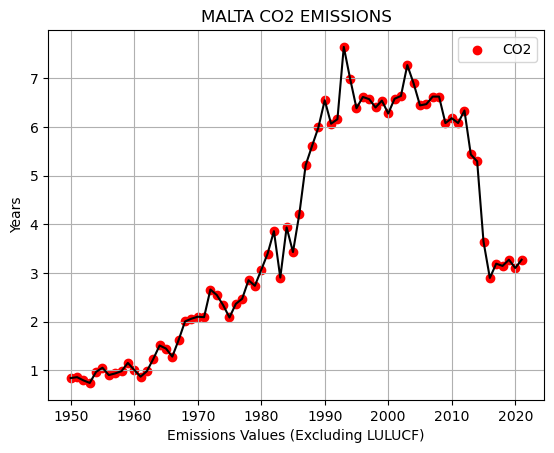

In [29]:
x, y = malta['Year'], malta['VALUE']
plt.scatter(x,y, color='red', label='CO2')
plt.plot(x,y, color='black')
plt.grid()
plt.legend()
plt.title('MALTA CO2 EMISSIONS')
plt.xlabel('Emissions Values (Excluding LULUCF)')
plt.ylabel('Years')
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#Transform input feature to include polynomial terms
degree = 4  # Set the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(x_poly, y_train)

print(model.score(x_poly,y_train))

0.9361730840761657


In [31]:
x_test, y_test = x_test[['Year']], x_test['VALUE']

In [32]:
x_test_poly = poly_features.transform(x_test)
y_pred = model.predict(x_test_poly)

print(model.score(x_test_poly,y_test))

# Print the predicted value
print("Predicted value:", y_test, y_pred)

0.9631802821614388
Predicted value: 19    2.060879
55    6.447007
10    1.009241
68    3.146826
53    7.275362
26    2.366697
39    5.993396
54    6.898066
Name: VALUE, dtype: float64 [1.63955836 6.57306395 0.76145865 3.68207491 6.65102498 2.87344172
 5.39941143 6.62223116]


In [33]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Coefficient of Determination (R-squared):', r2)

Mean Squared Error (MSE): 0.20209740584005476
Mean Absolute Error (MAE): 0.41641387342311903
Coefficient of Determination (R-squared): 0.9631802821614388


In [34]:
p = np.array([2022,2023,2030]).reshape(-1,1)
to_predict = poly_features.transform(p)
y_pred30 = model.predict(to_predict)
y_pred30

array([ 1.77159953,  1.20561484, -3.84614773])

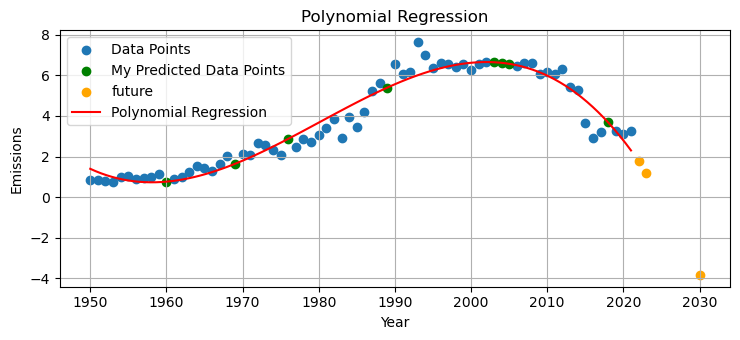

In [35]:
# Plot the original data points and the polynomial regression curve

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(x_range)

# Predict using the trained model
y_pred2 = model.predict(x_range_poly)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.scatter(X, y_train, label='Data Points')
plt.scatter(x_test, y_pred, label='My Predicted Data Points', color='green')
plt.scatter(p, y_pred30, color='orange', label='future')
plt.plot(x_range, y_pred2, color='r', label='Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.grid()
plt.legend()
plt.title('Polynomial Regression')
plt.show()